In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from sklearn.datasets import make_regression
import numpy as np
from statsmodels import api as sm
import tensorflow as tf
from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression
from matplotlib import pyplot as plt

In [188]:
bias = np.random.randn(8)

x, y, coef = make_regression(
    n_samples=10000,
    n_targets=8,
    bias=0,
    effective_rank=5,
    noise=1.0,
    coef=True,
)
y += bias

In [189]:
f = sm.OLS(y[:, 0], sm.add_constant(x)).fit()

In [ ]:
ridge_penalty

In [340]:
n_pls = 3
pls = PLSRegression(n_components=n_pls)
pls.fit(x, y)

na, nb, nc = 50, 30, 20
ridge_penalty = 0.01
ridge_model = Ridge(alpha=ridge_penalty)
ridge_model.fit(x, y)

Ridge(alpha=0.01)

In [191]:
la, lb, lc = 7, 5, 4  # number of cells

In [192]:
pls_inits = []
for ifrom, ito, l in [(0, na, la), (na, na + nb, lb), (na + nb, na + nb + nc, lc)]:
    model = PLSRegression(n_components=l)
    model.fit(x[:, ifrom:ito], y)
    pls_inits.append(model)

In [208]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

In [347]:
ridge_penalty = 1e-8

In [381]:
inputs = tf.keras.layers.Input(shape=(x.shape[1],))
xa, xb, xc = tf.split(inputs, num_or_size_splits=(na, nb, nc), axis=1)
npls_last = 4
initializer_noise = 1e-2

pls_layers = tf.keras.layers.concatenate(
    [
        tf.keras.layers.Dense(
            _l,
            kernel_regularizer=tf.keras.regularizers.l2(ridge_penalty),
            kernel_initializer=tf.constant_initializer(p.x_rotations_),
            bias_initializer=tf.constant_initializer(np.zeros(_l)),
            activation="gelu",
        )(_x)
        for (p, _x, _l, _n) in zip(pls_inits, (xa, xb, xc), (la, lb, lc), (na, nb, nc))
    ]
)

hidden = tf.keras.layers.Dense(
    npls_last,
    kernel_regularizer=tf.keras.regularizers.l2(ridge_penalty),
    activation="gelu",
)(pls_layers)

output = tf.keras.layers.Dense(
    y.shape[1],
    kernel_regularizer=tf.keras.regularizers.l2(ridge_penalty),
    kernel_initializer=tf.constant_initializer(
        np.vstack(
            [
                ridge_model.coef_.T,
                initializer_noise * np.random.randn(npls_last, y.shape[1]),
            ]
        )
    ),
    bias_initializer=tf.constant_initializer(ridge_model.intercept_),
)(tf.keras.layers.concatenate([inputs, hidden]))

model = tf.keras.Model(inputs=inputs, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=optimizer, loss="mse", jit_compile=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=100,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
)

Epoch 1/100
90/90 [==============================] - 1s 3ms/step - loss: 1.2293 - val_loss: 1.0883
Epoch 2/100
90/90 [==============================] - 0s 853us/step - loss: 1.0520 - val_loss: 1.0326
Epoch 3/100
90/90 [==============================] - 0s 799us/step - loss: 1.0258 - val_loss: 1.0136
Epoch 4/100
90/90 [==============================] - 0s 832us/step - loss: 1.0179 - val_loss: 1.0144
Epoch 5/100
90/90 [==============================] - 0s 808us/step - loss: 1.0124 - val_loss: 1.0297
Epoch 6/100
90/90 [==============================] - 0s 800us/step - loss: 1.0091 - val_loss: 1.0114
Epoch 7/100
90/90 [==============================] - 0s 792us/step - loss: 1.0095 - val_loss: 1.0049
Epoch 8/100
90/90 [==============================] - 0s 802us/step - loss: 1.0051 - val_loss: 1.0052
Epoch 9/100
90/90 [==============================] - 0s 752us/step - loss: 1.0067 - val_loss: 1.0215
Epoch 10/100
90/90 [==============================] - 0s 771us/step - loss: 1.0013 - val_loss

In [366]:
output = tf.keras.layers.Dense(y.shape[1])(inputs)

model = tf.keras.Model(inputs=inputs, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=optimizer, loss="mse", jit_compile=True)

history = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=100,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/50
90/90 [==============================] - 0s 1ms/step - loss: 1.3263 - val_loss: 1.1255
Epoch 2/50
90/90 [==============================] - 0s 840us/step - loss: 1.1057 - val_loss: 1.0777
Epoch 3/50
90/90 [==============================] - 0s 650us/step - loss: 1.0720 - val_loss: 1.0574
Epoch 4/50
90/90 [==============================] - 0s 673us/step - loss: 1.0515 - val_loss: 1.0441
Epoch 5/50
90/90 [==============================] - 0s 665us/step - loss: 1.0389 - val_loss: 1.0301
Epoch 6/50
90/90 [==============================] - 0s 657us/step - loss: 1.0294 - val_loss: 1.0239
Epoch 7/50
90/90 [==============================] - 0s 646us/step - loss: 1.0220 - val_loss: 1.0201
Epoch 8/50
90/90 [==============================] - 0s 663us/step - loss: 1.0178 - val_loss: 1.0139
Epoch 9/50
90/90 [==============================] - 0s 663us/step - loss: 1.0126 - val_loss: 1.0108
Epoch 10/50
90/90 [==============================] - 0s 643us/step - loss: 1.0095 - val_loss: 1.0090
E

In [370]:
np.linalg.norm(ridge_model.predict(x_train) - y_train)

266.84459434577644

In [369]:
np.linalg.norm(model.predict(x_train) - y_train)

282/282 [==============================] - 0s 375us/step


266.7639413931396

In [371]:
np.linalg.norm(ridge_model.predict(x) - y)

281.17569441266266

In [372]:
np.linalg.norm(model.predict(x) - y)

313/313 [==============================] - 0s 406us/step


281.39078699894384

313/313 [==============================] - 0s 381us/step


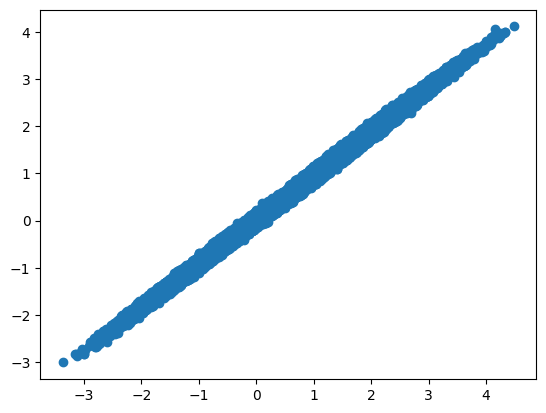

In [359]:
plt.scatter(model.predict(x), ridge_model.predict(x))

In [310]:
np.linalg.norm(ridge_model.predict(x) - y)

280.2963704371356

In [301]:
m = tf.keras.metrics.MeanSquaredError()
m.update_state(y_true=y, y_pred=ridge_model.predict(x))

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=10000.0>

In [302]:
m.result().numpy()

0.9820756

In [300]:
m.result().numpy()

1.0132341

In [ ]:
plt.scatter()

In [226]:
model = tf.keras.Model(inputs=inputs, outputs=output)

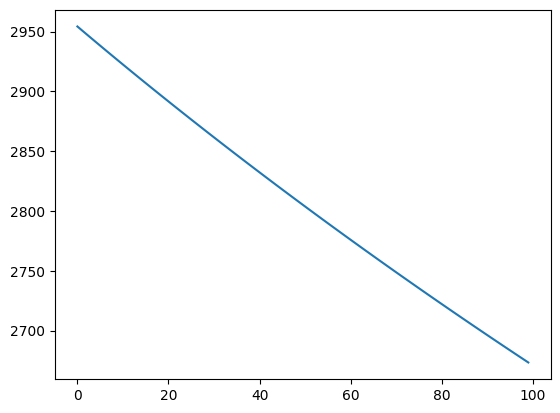

In [283]:
plt.plot(history.history["val_loss"])

In [261]:
np.linalg.norm(ridge_model.predict(x)[:, 0] - y[:, 0])

98.56729088142356

In [262]:
np.linalg.norm(model.predict(x)[:, 0] - y[:, 0])

313/313 [==============================] - 0s 396us/step


98.6401212321239

313/313 [==============================] - 0s 389us/step


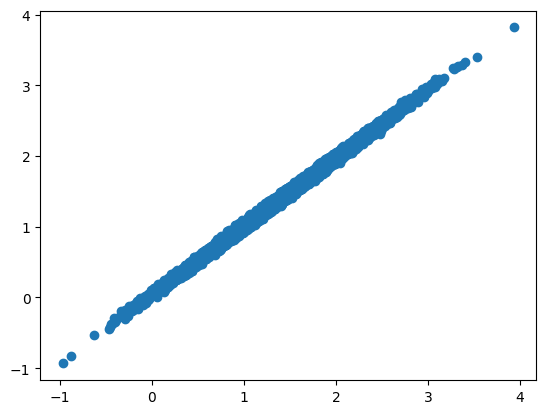

In [257]:
plt.scatter(ridge_model.predict(x)[:, 0], model.predict(x)[:, 0])

# plt.scatter(f.fittedvalues, y[:, 0])

In [37]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(x.shape[1],)),
        SplitDenseLayer(50, 30, 20),
        tf.keras.layers.Dense(y.shape[1]),
    ]
)

model.set_weights

# Compile the model with Adam optimizer and Mean Squared Error loss
model.compile(optimizer="rmsprop", loss="mse", jit_compile=True)

# Train the model for 10 epochs with a batch size of 32
model.fit(x, y, epochs=100, batch_size=32)

Epoch 1/100
32/32 [==============================] - 0s 3ms/step - loss: 4.3725
Epoch 2/100
32/32 [==============================] - 0s 613us/step - loss: 4.3342
Epoch 3/100
32/32 [==============================] - 0s 613us/step - loss: 4.2963
Epoch 4/100
32/32 [==============================] - 0s 581us/step - loss: 4.2566
Epoch 5/100
32/32 [==============================] - 0s 613us/step - loss: 4.2123
Epoch 6/100
32/32 [==============================] - 0s 710us/step - loss: 4.1648
Epoch 7/100
32/32 [==============================] - 0s 645us/step - loss: 4.1134
Epoch 8/100
32/32 [==============================] - 0s 613us/step - loss: 4.0587
Epoch 9/100
32/32 [==============================] - 0s 613us/step - loss: 4.0005
Epoch 10/100
32/32 [==============================] - 0s 613us/step - loss: 3.9380
Epoch 11/100
32/32 [==============================] - 0s 645us/step - loss: 3.8729
Epoch 12/100
32/32 [==============================] - 0s 581us/step - loss: 3.8070
Epoch 13/100
32

32/32 [==============================] - 0s 871us/step


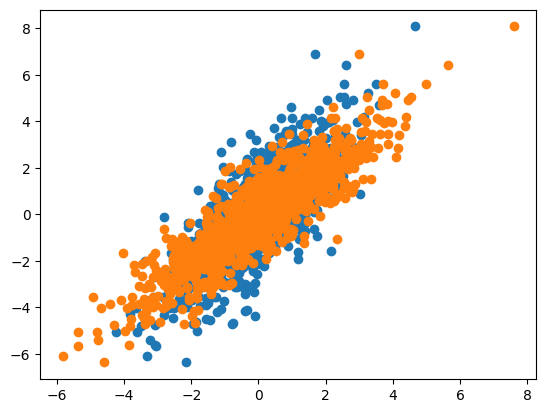

In [38]:
plt.scatter(model.predict(x)[:, 0], y[:, 0])
plt.scatter(f.fittedvalues, y[:, 0])

In [40]:
dir(model)

['_SCALAR_UPRANKING_ON',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_aggregate_exact_metrics',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_get_config',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_graph_network_for_inferred_shape',
 '_build_input_shape',
 '_call_spec',
 '_callable_losses',
 '_captured_weight_regularizer',
 '_cast_single_input',
 '_check_call_args',
 '_chec

In [ ]:
plt.scatter(fit.predict(x), y)